In [2]:
%pylab inline
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split #to split in train and test set
from sklearn.linear_model import LogisticRegression #logistic regression classifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score #BONUS: to tune parameters using cross-validation
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [13]:
#Data is a bunch of columns with different features.
#1 - month
#3 - day of the week
#4 - airline
#7 - departure airport
#8 - arrival airport
#9 - departure time
#and also target:
#11 - delay time -> later converted into 0-1 value of delay/ontime

my_data = pd.read_csv('balancedset.csv', usecols=[1,3,4,7,8,9,11])

# randomizes data
my_data = my_data.sample(frac=1)

# Create a set of dummy variables from the variable. 
# They say all over the internets that this is how you're supposed to handle categorical vars like strings etc.
df_dummies = pd.get_dummies(my_data.iloc[:,[2,3,4]])

#convert hours and minutes to just hours
for index, row in my_data.iterrows():
    hour = math.floor(int(row[5])/100)
    minutes = int(row[5])/100 - hour
    if minutes < .3:
        row[5] = hour
    else:
        row[5] = hour + 1

#get values for the target (delay on departure)
yVal = np.array(my_data.iloc[:,[6]]).reshape(shape(my_data)[0],)
y = []

#delay has 4 values: on time (0), slight delay (1), medium delay (2) significant delay (3)
for value in yVal:
    if value <=10:
        tgt = 0    
    else: #value > 10 
        tgt = 1
    y.append(tgt)


#remove targets and columns that were converted into dummy variables
my_data = my_data.drop(my_data.columns[[2, 3, 4, 6]], axis=1)

#concat my_data and dummies and generate a np.ndarray of features
df_new = pd.concat([my_data, df_dummies], axis=1)
X = df_new.values

# Scale X
X = preprocessing.scale(X) 



#split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



C:\Users\doria\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [14]:
print(shape(X))

(406558, 246)


In [55]:
### NOTE: SVM Runs too slow, do not attempt at this moment

def svm():
    
    #prepare c-values for cross validation
    cVal = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    
    print('------------------------SUPPORT VECTOR MACHINE:------------------------')
    print('');
    print('Cross-Validation: means & stds for given c-values');
    #define the classifier
    cv_svmClass = LinearSVC(class_weight="balanced")
    #use GridSearchCV to generate the best c-value for a classifier, from the cVal array
    cv_svm = GridSearchCV(estimator=cv_svmClass, param_grid = dict(C=cVal), cv=10, scoring='accuracy')
    cv_svm.fit(X_train, y_train)
    #print the mean and s.dev. scores for every c-value for comparison
    means_cv_svm = cv_svm.cv_results_['mean_test_score']
    stds_cv_svm = cv_svm.cv_results_['std_test_score']

    #fit the data
    #get the best c-value from grid search
    best = cv_svm.best_params_['C']
    
    #define logistic regression using the best value
    cv_svmBest = LinearSVC(C=best, class_weight="balanced")
    #fit the training data
    cv_svmBest.fit(X_train, y_train)
    #get the estimates
    predicted = cv_svmBest.predict(X_test)
    
    print('Best score: {}'.format(best))
    print()
    print('Classification report for the best c-parameter (test set):')
    print(classification_report(y_test, predicted))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_test, predicted))  
    
svm()

------------------------SUPPORT VECTOR MACHINE:------------------------

Cross-Validation: means & stds for given c-values


KeyboardInterrupt: 

------------------------RANDOM FOREST:------------------------

Cross-Validation: means & stds for given

Best score: 14

Classification report for the best c-parameter (test set):
             precision    recall  f1-score   support

          0       0.71      0.61      0.66     45946
          1       0.57      0.68      0.62     35366

avg / total       0.65      0.64      0.64     81312


Confusion matrix for the best c-parameter (test set):
[[28143 17803]
 [11359 24007]]


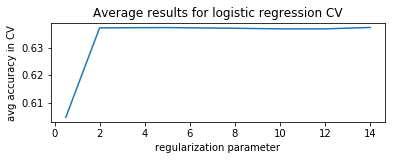

In [23]:
def forest():
    
    #prepare c-values for cross validation
    cVal = [0.5, 2, 5, 8, 10, 12, 14]
    
    print('------------------------RANDOM FOREST:------------------------')
    print('');
    print('Cross-Validation: means & stds for given');
    #define the classifier
    cv_forestClass = RandomForestClassifier(class_weight="balanced", n_estimators=80, max_features=0.3, max_depth=8)
    #use GridSearchCV to generate the best c-value for a classifier, from the cVal array
    cv_forest = GridSearchCV(estimator=cv_forestClass, param_grid = dict(min_samples_split=cVal), cv=10, scoring='accuracy')
    #fit the data
    cv_forest.fit(X_train, y_train)
    #print the mean and s.dev. scores for every c-value for comparison
    means_cv_forest = cv_forest.cv_results_['mean_test_score']
    stds_cv_forest = cv_forest.cv_results_['std_test_score']
    #for mean, std, params in zip(means_cv_reg, stds_cv_reg, cv_reg.cv_results_['params']):
        #print("Mean: %0.5f | Standard Deviation:(+/-%0.03f) | for %r" % (mean, std * 2, params))
    #print()
    
    #plot the mean accuracies for logistic regression CV
    ax1 = plt.subplot("211")
    ax1.set_title("Average results for logistic regression CV")
    ax1.set_ylabel('avg accuracy in CV')
    ax1.set_xlabel('regularization parameter')
    ax1.plot(cVal, means_cv_forest)
    print()
    
    #get the best c-value from grid search
    best = cv_forest.best_params_['min_samples_split']
    #define logistic regression using the best value
    cv_forestBest = RandomForestClassifier(min_samples_split=best, class_weight="balanced", n_estimators=80, max_features=0.3, max_depth=8)
    #fit the training data
    cv_forestBest.fit(X_train, y_train)
    #get the estimates
    predicted = cv_forestBest.predict(X_test)
    
    print('Best score: {}'.format(best))
    print()
    print('Classification report for the best c-parameter (test set):')
    print(classification_report(y_test, predicted))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_test, predicted))
    
forest()

------------------------LOGISTIC REGRESSION:------------------------

Cross-Validation: means & stds for given c-values

Best score: 0.0003

Classification report for the best c-parameter (train set):
             precision    recall  f1-score   support

          0       0.70      0.65      0.67    183368
          1       0.58      0.64      0.61    141878

avg / total       0.65      0.64      0.65    325246


Confusion matrix for the best c-parameter (test set):
[[118765  64603]
 [ 51264  90614]]

Classification report for the best c-parameter (test set):
             precision    recall  f1-score   support

          0       0.70      0.65      0.68     45946
          1       0.59      0.64      0.61     35366

avg / total       0.65      0.65      0.65     81312


Confusion matrix for the best c-parameter (test set):
[[29940 16006]
 [12736 22630]]


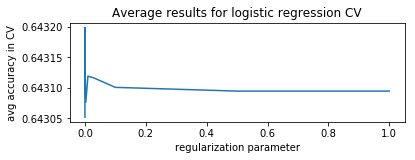

In [22]:
def logRegr():
    
    #prepare c-values for cross validation
    cVal = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.5, 1.]
    
    print('------------------------LOGISTIC REGRESSION:------------------------')
    print('');
    print('Cross-Validation: means & stds for given c-values');
    #define the classifier
    cv_regClass = LogisticRegression(class_weight="balanced")
    #use GridSearchCV to generate the best c-value for a classifier, from the cVal array
    cv_reg = GridSearchCV(estimator=cv_regClass, param_grid = dict(C=cVal), cv=10, scoring='accuracy')
    #fit the data
    cv_reg.fit(X_train, y_train)
    #print the mean and s.dev. scores for every c-value for comparison
    means_cv_reg = cv_reg.cv_results_['mean_test_score']
    stds_cv_reg = cv_reg.cv_results_['std_test_score']
    #for mean, std, params in zip(means_cv_reg, stds_cv_reg, cv_reg.cv_results_['params']):
        #print("Mean: %0.5f | Standard Deviation:(+/-%0.03f) | for %r" % (mean, std * 2, params))
    #print()
    
    #plot the mean accuracies for logistic regression CV
    ax1 = plt.subplot("211")
    ax1.set_title("Average results for logistic regression CV")
    ax1.set_ylabel('avg accuracy in CV')
    ax1.set_xlabel('regularization parameter')
    ax1.plot(cVal, means_cv_reg)
    print()
    
    #get the best c-value from grid search
    best = cv_reg.best_params_['C']
    #define logistic regression using the best value
    cv_regBest = LogisticRegression(C=best, class_weight="balanced")
    #fit the training data
    cv_regBest.fit(X_train, y_train)
    #get the estimates
    predictedtrain = cv_regBest.predict(X_train)
    predictedtest = cv_regBest.predict(X_test)
    
    print('Best score: {}'.format(best))
    print()
    print('Classification report for the best c-parameter (train set):')
    print(classification_report(y_train, predictedtrain))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_train, predictedtrain))
    print()
    print('Classification report for the best c-parameter (test set):')
    print(classification_report(y_test, predictedtest))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_test, predictedtest))
    
logRegr()

------------------------NEURAL NETWORK:------------------------

Cross-Validation: means & stds for given

Best score: (30, 30, 30)

Classification report for the best c-parameter (train set):
             precision    recall  f1-score   support

          0       0.70      0.75      0.73    183368
          1       0.65      0.59      0.62    141878

avg / total       0.68      0.68      0.68    325246


Confusion matrix for the best c-parameter (train set):
[[137490  45878]
 [ 58045  83833]]
Classification report for the best c-parameter (test set):
             precision    recall  f1-score   support

          0       0.69      0.73      0.71     45946
          1       0.62      0.57      0.59     35366

avg / total       0.66      0.66      0.66     81312


Confusion matrix for the best c-parameter (test set):
[[33593 12353]
 [15311 20055]]


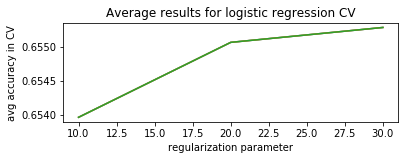

In [21]:
def mlp():
    

    #prepare c-values for cross validation
    hidden = [(10,10,10), (20,20,20), (30,30,30)] # NOTE (2,) is a single layer with 2 nodes
    
    print('------------------------NEURAL NETWORK:------------------------')
    print('');
    print('Cross-Validation: means & stds for given');
    #define the classifier
    cv_mlpClass = MLPClassifier()
    #use GridSearchCV to generate the best c-value for a classifier, from the cVal array
    cv_mlp = GridSearchCV(estimator=cv_mlpClass, param_grid = dict(hidden_layer_sizes=hidden), cv=10, scoring='accuracy')
    #fit the data
    cv_mlp.fit(X_train, y_train)
    #print the mean and s.dev. scores for every c-value for comparison
    means_cv_mlp = cv_mlp.cv_results_['mean_test_score']
    stds_cv_mlp = cv_mlp.cv_results_['std_test_score']
    #for mean, std, params in zip(means_cv_reg, stds_cv_reg, cv_reg.cv_results_['params']):
        #print("Mean: %0.5f | Standard Deviation:(+/-%0.03f) | for %r" % (mean, std * 2, params))
    #print()
    
    #plot the mean accuracies for logistic regression CV
    ax1 = plt.subplot("211")
    ax1.set_title("Average results for logistic regression CV")
    ax1.set_ylabel('avg accuracy in CV')
    ax1.set_xlabel('regularization parameter')
    ax1.plot(hidden, means_cv_mlp)
    print()
    
    #get the best c-value from grid search
    best = cv_mlp.best_params_['hidden_layer_sizes']
    #define logistic regression using the best value
    cv_mlpBest = MLPClassifier(hidden_layer_sizes=best)
    #fit the training data
    cv_mlpBest.fit(X_train, y_train)
    #get the estimates
    predictedtrain = cv_mlpBest.predict(X_train)
    predictedtest = cv_mlpBest.predict(X_test)
    
    print('Best score: {}'.format(best))
    print()
    print('Classification report for the best c-parameter (train set):')
    print(classification_report(y_train, predictedtrain))
    print()
    print('Confusion matrix for the best c-parameter (train set):')
    print(metrics.confusion_matrix(y_train, predictedtrain))
    print('Classification report for the best c-parameter (test set):')
    print(classification_report(y_test, predictedtest))
    print()
    print('Confusion matrix for the best c-parameter (test set):')
    print(metrics.confusion_matrix(y_test, predictedtest))
    
mlp()

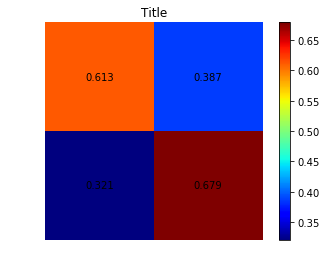

In [5]:
import numpy as np
import matplotlib.pyplot as plt

TP = round(28143 / 45946 , 3)
FP = round(17803 / 45946 , 3)
FN = round(11359 / 35366 , 3)
TN = round(24007 / 35366 , 3)


conf_arr = np.array([[TP,FP],
            [FN,TN]])

norm_conf = []

for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(2):
    for y in range(2):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
plt.axis('off')
plt.title('Title')
cb = fig.colorbar(res)